Introduction

This project will predict if a customer will churn or not. Training two different models

-  A Logistic Regression model
-  A Random Forest model

First is to import the needed libraries to build the models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import ipywidgets as widgets
from IPython.display import display
import pickle

Data loading, understanding, and preprocessing

The data will be loaded from a csv file and saved into a pandas dataframe. The dataset csv file is from the Telco Customer Churn dataset from Kaggle.

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.shape

(7043, 21)

In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Now that the dataset has been loaded we see that this dataset has 7043 rows and 21 columns. And there are no missing values in any of the columns.

Preprocessing the data for analysis

In [7]:
# Drop the unnecessary columns
df = df.drop(columns = ["customerID"])

# Convert the TotalCharges column to a numerical column instead of an object data type and handle any missing values or empty space
df['TotalCharges'] = df['TotalCharges'].replace({' ' : '0.0'})
df['TotalCharges'] = df['TotalCharges'].astype(float)

To get an idea if the column is either a numerical column or a categorical column we print out all the unique values in all the columns

In [8]:
# Printing the unique values in all the columns
for column in df.columns:
    print(column, df[column].unique())
    print(" ")

gender ['Female' 'Male']
 
SeniorCitizen [0 1]
 
Partner ['Yes' 'No']
 
Dependents ['No' 'Yes']
 
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
 
PhoneService ['No' 'Yes']
 
MultipleLines ['No phone service' 'No' 'Yes']
 
InternetService ['DSL' 'Fiber optic' 'No']
 
OnlineSecurity ['No' 'Yes' 'No internet service']
 
OnlineBackup ['Yes' 'No' 'No internet service']
 
DeviceProtection ['No' 'Yes' 'No internet service']
 
TechSupport ['No' 'Yes' 'No internet service']
 
StreamingTV ['No' 'Yes' 'No internet service']
 
StreamingMovies ['No' 'Yes' 'No internet service']
 
Contract ['Month-to-month' 'One year' 'Two year']
 
PaperlessBilling ['Yes' 'No']
 
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
 
MonthlyCharges [29.85 56.95 53.85 ... 63.1  44.2  

From this we can see that most likely the numerical columns are the tenure, monthly charges, and total charges columns. Everything else is a categorical column.

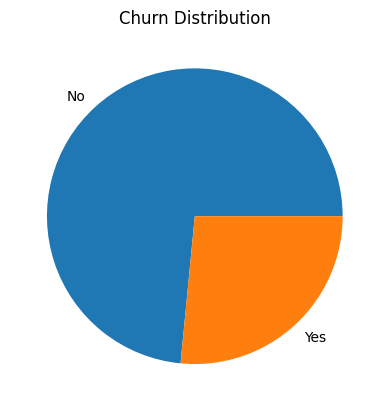

In [9]:
# Checking the distribution of the target column(churn)
df["Churn"].value_counts().plot(kind="pie")
plt.title("Churn Distribution")
plt.ylabel("")
plt.show()

From here we can see that there are a lot more "No" than there are "Yes".

Understanding the numerical columns

In [10]:
df.groupby("Churn")["tenure"].mean()

Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64

In [11]:
df.groupby("Churn")["MonthlyCharges"].mean()

Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64

From these we see that for tenure typically people who stay longer have a lower probability to churn, whereas higher monthly charges mean a higher probability to churn.

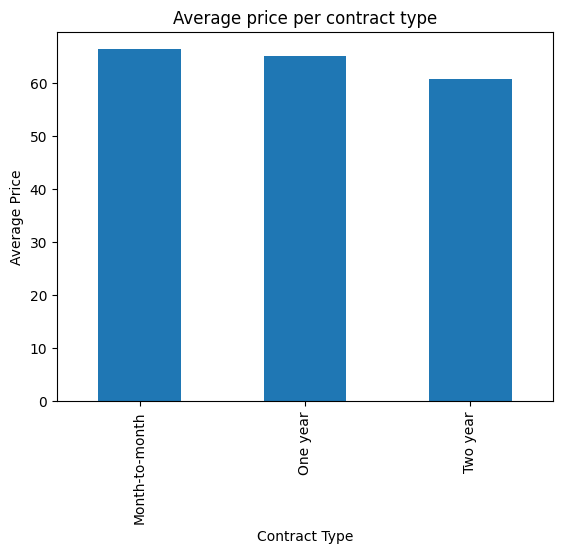

In [12]:
df.groupby("Contract")["MonthlyCharges"].mean().plot(kind="bar")
plt.title("Average price per contract type")
plt.ylabel("Average Price")
plt.xlabel("Contract Type")
plt.show()

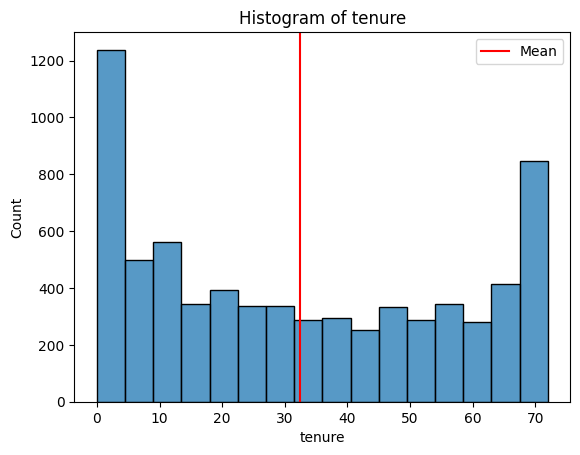

In [13]:
# Histogram for tenure, MonthlyCharges, and Total Charges for distribution
sns.histplot(df["tenure"])
plt.title("Histogram of tenure")
column_mean = df["tenure"].mean()
plt.axvline(column_mean, color = "red", label = "Mean")
plt.legend()
plt.show()

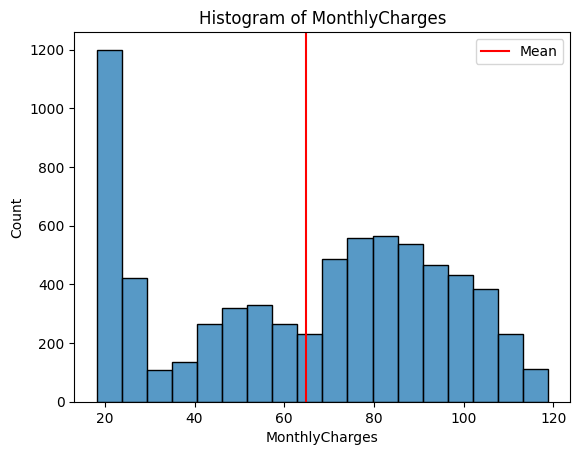

In [14]:
sns.histplot(df["MonthlyCharges"])
plt.title("Histogram of MonthlyCharges")
column_mean = df["MonthlyCharges"].mean()
plt.axvline(column_mean, color = "red", label = "Mean")
plt.legend()
plt.show()

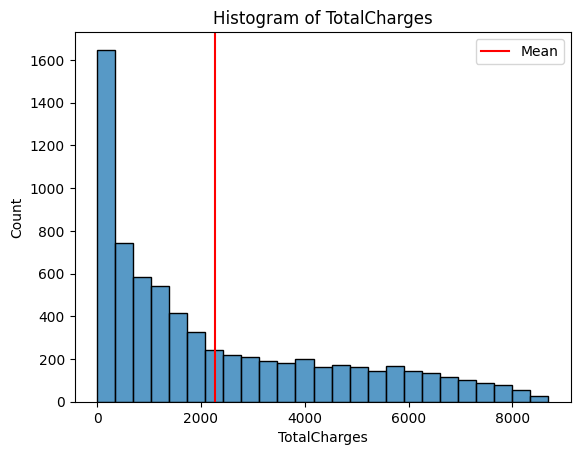

In [15]:
sns.histplot(df["TotalCharges"])
plt.title("Histogram of TotalCharges")
column_mean = df["TotalCharges"].mean()
plt.axvline(column_mean, color = "red", label = "Mean")
plt.legend()
plt.show()

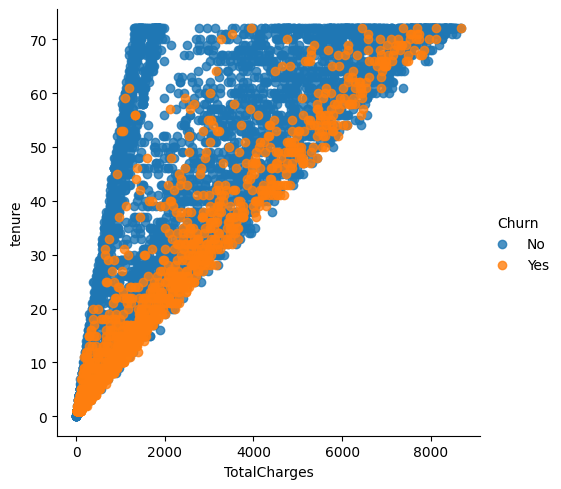

In [16]:
# Scatterplot for correlations
sns.lmplot(x = "TotalCharges", y = "tenure", data = df, fit_reg = False, hue = "Churn")
plt.show()

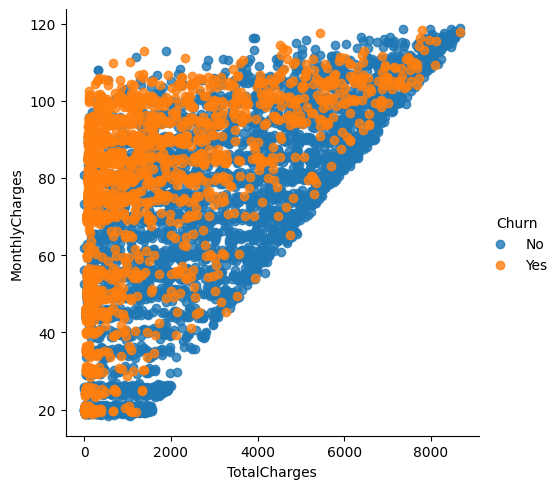

In [17]:
sns.lmplot(x = "TotalCharges", y = "MonthlyCharges", data = df, fit_reg = False, hue = "Churn")
plt.show()

Processing the data for model building

In [18]:
# Label encoding the categorical columns
object_columns = df.select_dtypes(include = ["object"]).columns.to_list()
encoders = {}

for column in object_columns:
    encoded_label = LabelEncoder()
    df[column] = encoded_label.fit_transform(df[column])
    encoders[column] = encoded_label

# Save the encoders to a file
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

# Convert the Churn column to have 1 for yes and 0 for no
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


After running the above code the customerID column has been dropped, the TotalCharges column should now be a float data type column and have no missing values or any missing spaces, the numerical columns have been encoded, and the Churn target column will have 1s and 0s instead of yes and no.

In [19]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


Building the model

To build the model includes:

- Processing the data for modeling
- Training the two models
- Analyzing the performance for both

In [21]:
# Split the target columns and the features
X = df.drop(columns='Churn')
y = df['Churn']

# Training set and test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Applying SMOTE to the training set
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale the numeric features
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

# save the scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

After running the above here is what happens:

- X now contains all features except Churn. Y contains the target label.
- The data in now split into X_train and X_test for the features data, and y_train and y_test for the target labels for training and testing
- SMOTE to upsample the minority class, in this case where churn = 1, in the training set. The both training sets are now balanced.
- StandardScaler to scale the features in the x_training set and x_test set

In [22]:
y_train_smote.value_counts()

Churn
0    4138
1    4138
Name: count, dtype: int64

In [23]:
print(pd.DataFrame(X_train_smote).head())

         0         1         2         3         4         5         6   \
0 -0.884355 -0.392342 -0.783106  1.923435 -0.289916  0.347565 -0.971244   
1 -0.884355 -0.392342 -0.783106 -0.519903  1.095216  0.347565  1.181700   
2  1.130767 -0.392342  1.276966 -0.519903 -1.129390 -2.877156  0.105228   
3  1.130767 -0.392342 -0.783106 -0.519903 -1.003469  0.347565 -0.971244   
4  1.130767 -0.392342 -0.783106  1.923435 -1.171363  0.347565  1.181700   

         7         8         9         10        11        12        13  \
0 -1.229210  1.717116 -0.898601  1.438621 -0.766097 -1.037917  1.200562   
1  0.246841 -0.758426  1.433787 -0.892238 -0.766097  1.218104  1.200562   
2 -1.229210 -0.758426 -0.898601 -0.892238 -0.766097 -1.037917 -1.049659   
3  0.246841 -0.758426 -0.898601 -0.892238 -0.766097 -1.037917 -1.049659   
4 -1.229210  1.717116  1.433787 -0.892238  1.705724 -1.037917 -1.049659   

         14        15        16        17        18  
0  0.667090 -1.211708  1.465229 -0.110101 -0

Model Training and comparison

In [24]:
# Training the models and comparing the with cross-validation
models = {
    "Logistic Regression": LogisticRegression(max_iter = 1000, random_state = 42),
    "Random Forest": RandomForestClassifier(random_state = 42)
}

for model_name, model in models.items():
    print(f"Training {model_name} model...")
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    print(f"{model_name} cross validation accuracy: {np.mean(scores):.2f}")
    print(f"{model_name} Standard Deviation: {np.std(scores):.2f}")
    print(" ")

Training Logistic Regression model...
Logistic Regression cross validation accuracy: 0.79
Logistic Regression Standard Deviation: 0.04
 
Training Random Forest model...
Random Forest cross validation accuracy: 0.84
Random Forest Standard Deviation: 0.07
 


From this we get that for the Logistic regression model accuracy is worse than the random forest model, but is more stable across different data splits, whereas the random forest has a higher accuracy meaning it performs better on average.

The Random Forest model will be going forward to model evaluation and will be used to make the predictive model

Model Evaluation and making the predictive model

In [25]:
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_smote, y_train_smote)

# Evaluate on test data
y_pred = final_model.predict(X_test)

print("Accuracy Score:\n", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save model
with open("final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)


Accuracy Score:
 0.7799858055358411
Confusion Matrix:
 [[884 152]
 [158 215]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.59      0.58      0.58       373

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409



Testing on custom input

In [26]:
with open("encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

input_data = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 1,
    "PhoneService": "No",
    "MultipleLines": "No phone service",
    "InternetService": "DSL",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 29.85,
    "TotalCharges": 29.85
}

input_data_df = pd.DataFrame([input_data])

for column, encoder in encoders.items():
    if column in input_data_df.columns:
        input_data_df[column] = encoder.transform(input_data_df[column])

input_data_scaled = scaler.transform(input_data_df)

In [27]:
print(input_data_df.head())

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  
0                 1              2           29.85         29.85  


In [28]:
with open("final_model.pkl", "rb") as f:
    final_model = pickle.load(f)

prediction = final_model.predict(input_data_scaled)
print("Prediction:", "Churn" if prediction[0] == 1  else "No Churn")

Prediction: No Churn


Interactive queries

In [29]:
# Get user input
gender = widgets.Dropdown(options=["Male", "Female"], description="Gender:")
senior_citizen = widgets.Dropdown(options=[("No", 0), ("Yes", 1)], description="Senior:"
)
partner = widgets.Dropdown(options=["Yes", "No"], description="Partner:")
dependents = widgets.Dropdown(options=["Yes", "No"], description="Dependents:")
tenure = widgets.BoundedIntText(min=0, max=100, value=12, description="Tenure:")
phone_service = widgets.Dropdown(options=["Yes", "No"], description="Phone:")
multiple_lines = widgets.Dropdown(options=["Yes", "No", "No phone service"], description="Multiple Lines:")
internet_service = widgets.Dropdown(options=["DSL", "Fiber optic", "No"], description="Internet Service:")
online_security = widgets.Dropdown(options=["Yes", "No", "No internet service"], description="Online Security:")
online_backup = widgets.Dropdown(options=["Yes", "No", "No internet service"], description="Online Backup:")
device_protection = widgets.Dropdown(options=["Yes", "No", "No internet service"], description="Device Protection:")
tech_support = widgets.Dropdown(options=["Yes", "No", "No internet service"], description="Tech Support:")
streaming_tv = widgets.Dropdown(options=["Yes", "No", "No internet service"], description="Streaming TV:")
streaming_movies = widgets.Dropdown(options=["Yes", "No", "No internet service"], description="Streaming Movies:")
contract = widgets.Dropdown(options=["Month-to-month", "One year", "Two year"], description="Contract:")
paperless_billing = widgets.Dropdown(options=["Yes", "No"], description="Paperless Billing:")
payment_method = widgets.Dropdown(
    options=[
        "Electronic check",
        "Mailed check",
        "Bank transfer (automatic)",
        "Credit card (automatic)"
    ],
    description="Payment Method:"
)
monthly_charges = widgets.BoundedFloatText(min=0.0, max=1000.0, value=70.35, description="Monthly Charges:")

# Button
predict_button = widgets.Button(description="Predict Churn", button_style="success")
button_output = widgets.Label(value="Enter values and press the Predict Churn button.")

# Load saved encoders, scaler, and model
with open("encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("final_model.pkl", "rb") as f:
    model = pickle.load(f)

# Callback function
def on_predict_clicked(b):
        # Build input dictionary
        user_data = {
            "gender": gender.value,
            "SeniorCitizen": senior_citizen.value,
            "Partner": partner.value,
            "Dependents": dependents.value,
            "tenure": tenure.value,
            "PhoneService": phone_service.value,
            "MultipleLines": multiple_lines.value,
            "InternetService": internet_service.value,
            "OnlineSecurity": online_security.value,
            "OnlineBackup": online_backup.value,
            "DeviceProtection": device_protection.value,
            "TechSupport": tech_support.value,
            "StreamingTV": streaming_tv.value,
            "StreamingMovies": streaming_movies.value,
            "Contract": contract.value,
            "PaperlessBilling": paperless_billing.value,
            "PaymentMethod": payment_method.value,
            "MonthlyCharges": monthly_charges.value,
            "TotalCharges": tenure.value * monthly_charges.value
        }

        # Save the user data to a data frame
        user_data_df = pd.DataFrame([user_data])

        # Encode
        for column, encoder in encoders.items():
            if column in user_data_df.columns:
                user_data_df[column] = encoder.transform(user_data_df[column])

        # Scale
        user_data_scaled = scaler.transform(user_data_df)

        # Predict
        prediction = model.predict(user_data_scaled)

        # Probability
        probability = model.predict_proba(user_data_scaled)[0][1]

        # Change the button output to show the prediction
        button_output.value = f"Prediction: {"Churn" if prediction[0] == 1 else "No Churn"} (Probability: {probability:.2%})"

# Connect button
predict_button.on_click(on_predict_clicked)

# Display all widgets
display(widgets.VBox([
    gender, senior_citizen, partner, dependents, tenure,
    phone_service, multiple_lines, internet_service,
    online_security, online_backup, device_protection,
    tech_support, streaming_tv, streaming_movies,
    contract, paperless_billing, payment_method,
    monthly_charges, predict_button, button_output
]))